In [1]:
import numpy as np
import os
from biopandas.pdb import PandasPdb
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import Bio
from Bio.PDB import PDBParser
from scipy.spatial.distance import cdist
import itertools
import utility_2
from descriptor_calc import GNM, MFD, local_OPD, Protrusion_Index, GT_curvature
import sys
# import time
# from sklearn import preprocessing


In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
def CA_coord(np_name):
    
    coord1 = PandasPdb()
    coord1.read_pdb(os.path.join(nano_dir, np_name+'.pdb'))
    c1 = coord1.df['ATOM']
    c1 = c1[c1['element_symbol'] != 'H']  
    c1_all = pd.concat([c1['x_coord'], c1['y_coord'], c1['z_coord']], axis=1).to_numpy()
    
    return c1, c1_all

def graph_curvature(c1, data_feature1):

    cutoff = 7
    cutoff_np = 4
    G1 = utility_2.make_graph_np(c1, cutoff_np)
    alpha = 0.5

    ollivier1 = np.array(GT_curvature.ollivier_ricci(G1))
    forman1 = np.array(GT_curvature.forman_ricci(G1))

    data_feature1['ollivier'] = ollivier1
    data_feature1['forman'] = forman1

    return data_feature1
    

def graph_gnm(c1_all, np_name, data_feature1):

    np_dir = os.path.join(nano_dir, np_name+'.pdb')
    gnm1 = np.array(GNM.gnm_sum_mode_np(np_dir, 10))

    print('gnm1', len(gnm1))

    if len(gnm1)==len(c1_all):
        data_feature1['gnm'] = gnm1
        print('1_same')
    elif len(gnm1)>len(c1_all):
        print('1_large')
    elif len(gnm1)<len(c1_all):
        print('1_small')


    return data_feature1
    
    
def graph_fd(c1, data_feature1):

    cutoff = 7
    cutoff_np = 4
    
    G1 = utility_2.make_graph_np(c1, cutoff_np)

    fd1 = MFD.fractal_dimension(G1)
    print('fractal dimension ok')

    r_d = 5
    more_fd1 = MFD.more_box(G1, r_d)
    r_d = 5
    more_fd1 = MFD.more_box(G1, r_d)

    data_feature1['fd'] = fd1[:, 1]
    data_feature1['more_fd_1'] = more_fd1[:, 1]
    data_feature1['more_fd_2'] = more_fd1[:, 2]
    data_feature1['more_fd_3'] = more_fd1[:, 3]
    data_feature1['more_fd_4'] = more_fd1[:, 4]

    return data_feature1
    
def graph_os(c1, data_feature1):

    G_os1_arr =local_OPD.GOS_single(c1)
    data_feature1['G_os_5'] = G_os1_arr[:, 0]
    data_feature1['G_os_7'] = G_os1_arr[:, 1]
    # data_feature1['G_os_10'] = G_os1_arr[:, 2]
    # data_feature1['G_os_15'] = G_os1_arr[:, 3]

    return data_feature1

    
def protrusion(c1, data_feature1):

    cutoff_cx = 10
    cx_1 = Protrusion_Index.cx_np(c1, cutoff_cx)
    data_feature1['cx'] = cx_1

    return data_feature1
    
def geometry(np_name, data_feature1, c1_all):

    geo_txt1 = os.path.join(geometry_dir, np_name+'.txt')
    shellAcc1, Rinacc1, Pocketness1 = np.loadtxt(geo_txt1, skiprows=43, usecols=(3,4,7), unpack=True)

    data_feature1['rd'] = Rinacc1[:len(c1_all)]
    data_feature1['shell'] = shellAcc1[:len(c1_all)]
    data_feature1['poc'] = Pocketness1[:len(c1_all)]

    return data_feature1

In [14]:
data_dir = os.getcwd()
protein_dir = os.path.join(data_dir, 'pdb_protein')
nano_dir = os.path.join(data_dir, 'pdb_protein')
geometry_dir = os.path.join(data_dir, 'geometry')
pair_table_dir = os.path.join(data_dir, 'pair_table')
data_feature_dir = os.path.join(data_dir, 'descriptors_matrix')
pts_dir = os.path.join(data_dir, 'pts')
np_name = 'conf_LPenNP'

In [23]:
c1, c1_all = CA_coord(np_name)
data_feature1 = {}

data_feature1 = geometry(np_name, data_feature1, c1_all)
print('geometry_fill ok')
data_feature1 = graph_curvature(c1, data_feature1)
print('graph_curvature_fill ok')
data_feature1 = graph_gnm(c1_all, np_name, data_feature1)
print('graph_gnm_fill ok')
data_feature1 = graph_fd(c1, data_feature1)
print('graph_fd_fill ok')
data_feature1 = protrusion(c1, data_feature1)
print('protrusion_fill ok')
data_feature1 = graph_os(c1, data_feature1)
print('os fill ok')

geometry_fill ok


@> 2790 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> Kirchhoff was built in 0.11s.


graph_curvature_fill ok


@> 2009 modes were calculated in 3.22s.


num mode is larger than 10
gnm1 2010
1_same
graph_gnm_fill ok
fractal dimension ok
graph_fd_fill ok
protrusion_fill ok
os fill ok


In [33]:
for item in data_feature1.keys():
   print(item, len(data_feature1[item]))  
data_feature1_pd = pd.DataFrame(data_feature1)
data_feature1_pd.to_csv(os.path.join(data_feature_dir, np_name + '_features.csv'),
                  index=False)

G_os_5 2010
G_os_7 2010
rd 2010
shell 2010
poc 2010
ollivier 2010
forman 2010
gnm 2010
fd 2010
more_fd_1 2010
more_fd_2 2010
more_fd_3 2010
more_fd_4 2010
cx 2010


Text(0.5, 0.92, 'L-CuS')

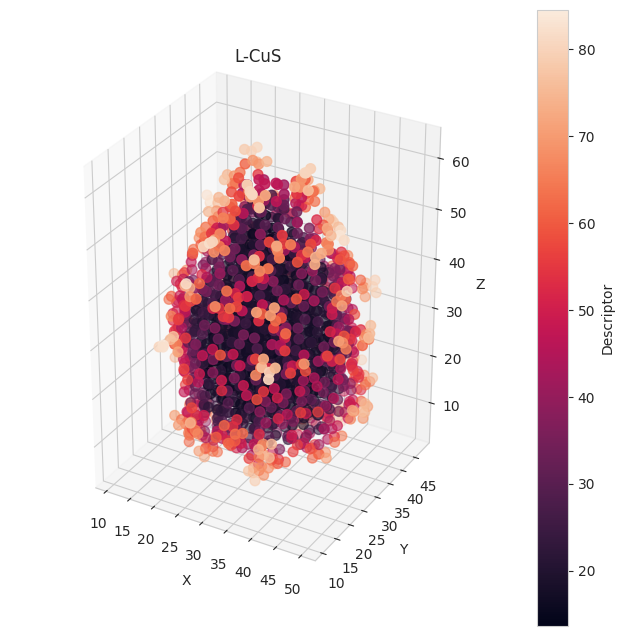

In [54]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


x=c1_all[:, 0]
y=c1_all[:, 1]
z=c1_all[:, 2]
feature = data_feature1_pd['shell']
sm = ScalarMappable(norm=plt.Normalize(min(feature), max(feature)))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, c=data_feature1_pd['shell'], s=50)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis('scaled')
fig.colorbar(sm,ax=plt.gca(), label = 'Descriptor')

plt.title('L-CuS')
# plt.axis('off')